In [1]:
!git clone https://github.com/LukeHackett12/MODRL.git

Cloning into 'MODRL'...
remote: Enumerating objects: 61, done.
remote: Counting objects: 100% (61/61), done.
remote: Compressing objects: 100% (47/47), done.
remote: Total 61 (delta 21), reused 49 (delta 12), pack-reused 0
Unpacking objects: 100% (61/61), done.


In [2]:
!ls

MODRL  sample_data


In [3]:
!pip install pyvirtualdisplay
!pip install gym --upgrade
!pip install piglet
!pip install pygame 

!apt-get install python-opengl -y
!apt install xvfb -y

     |████████████████████████████████| 1.6MB 17.8MB/s 
  Created wheel for gym: filename=gym-0.18.0-cp36-none-any.whl size=1656449 sha256=5fff151c69f4e1c2419ed5393efaf308640388f9bce739b4192e640025af5890
  Stored in directory: /root/.cache/pip/wheels/be/85/3b/480b828a4a697b37392740a040b8989f729d952b4e441a1877
Successfully built gym
  Found existing installation: gym 0.17.3
    Uninstalling gym-0.17.3:
      Successfully uninstalled gym-0.17.3
     |████████████████████████████████| 71kB 9.3MB/s 
     |████████████████████████████████| 92kB 10.3MB/s 
     |████████████████████████████████| 11.8MB 14.6MB/s 
Reading package lists... Done
Building dependency tree       
Reading state information... Done
Suggested packages:
  libgle3
The following NEW packages will be installed:
  python-opengl
0 upgraded, 1 newly installed, 0 to remove and 10 not upgraded.
Need to get 496 kB of archives.
After this operation, 5,416 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/u

In [4]:
import os
os.environ["SDL_VIDEODRIVER"] = "dummy"

In [30]:
from custom_envs.mountain_car.engine import MountainCar

import torch
from torch import FloatTensor, LongTensor, BoolTensor
from torch.autograd import Variable
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import transforms as T

import enum
import random
from collections import namedtuple, deque
from typing import NamedTuple

import numpy as np

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

from PIL import Image
from dqn_utils.dqn_models import Experience

In [22]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [23]:
class StatusEnum(enum.Enum):
    small = 1
    tall = 2
    fireball = 3

class Transition(NamedTuple):
    currStates: FloatTensor
    actions: LongTensor
    rewards: FloatTensor
    nextStates: FloatTensor
    dones: BoolTensor

In [24]:
class DQN(nn.Module):
    def __init__(self, input_shape, num_actions):
        super(DQN, self).__init__()
        self._input_shape = input_shape
        self._num_actions = num_actions

        self.features = nn.Sequential(
            nn.Conv2d(in_channels=input_shape[0], out_channels=32, kernel_size=8, stride=4),
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1),
            nn.ReLU(),
            nn.Flatten(),
        )

        self.fc = nn.Sequential(
            nn.Linear(self.feature_size, 512),
            nn.ReLU(),
            nn.Linear(512, num_actions)
        )

    def forward(self, x):
        x = self.features(x).view(x.size()[0], -1)
        return self.fc(x)
    
    @property
    def feature_size(self):
        x = self.features(torch.zeros(1, *self._input_shape))
        return x.view(1, -1).size(1)

In [26]:
class MarioAgent:
    def __init__(self, stateShape, actionSpace, numPicks, memorySize):
        self.numPicks = numPicks
        self.memorySize = memorySize
        self.replayMemory = Experience(memorySize, numPicks, 0.9)
        self.stateShape = stateShape
        self.actionSpace = actionSpace

        self.step = 0
        self.sync = 10

        self.alpha = 0.00025
        self.epsilon = 0.99
        self.epsilon_decay = 0.9999975
        self.epsilon_min=0.05
        self.eps_threshold = 0

        self.gamma = 0.999
        self.tau = 1e-3

        self.trainNetwork = DQN(stateShape, len(actionSpace)).to(device)
        self.targetNetwork = DQN(stateShape, len(actionSpace)).to(device)
        
        self.targetNetwork.load_state_dict(self.trainNetwork.state_dict())
        self.targetNetwork.eval()
        '''
        for p in self.trainNetwork.parameters():
            p.requires_grad = True
        for p in self.targetNetwork.parameters():
            p.requires_grad = False
        '''
        self.optimizer = optim.RMSprop(self.trainNetwork.parameters())

    def trainDQN(self):
        if self.step <= self.numPicks:
            return 1
        
        samples = self.replayMemory.select(0.9)
        batch = Transition(*zip(*samples[0]))
        currState,action,reward,nextState,done = batch

        '''
        states => actions
        need ideal actions => Q LERN
        '''
        '''currState, nextState, action, reward, done = map(
            torch.stack, zip(*samples))
        '''
        reward = torch.flatten(FloatTensor(reward)).to(device)
        done = torch.flatten(BoolTensor(done)).to(device)

        currState = torch.cat(currState)
        action = torch.cat(action)

        Q_current = self.trainNetwork(currState).gather(1, action.unsqueeze(1))
        
        nextStateNonFinal = torch.cat([s for s in nextState
                                                if s is not None])
        nonFinalMask = torch.tensor(tuple(map(lambda s: s is not None,
                                          nextState)), dtype=torch.bool).to(device)

        Q_futures = torch.zeros(self.numPicks, device=device)
        Q_futures[nonFinalMask] = self.targetNetwork(nextStateNonFinal.squeeze(1)).max(1)[0].detach()
       # Q_futures_best = torch.argmax(Q_futures, axis=1)
        #Q_next = self.trainNetwork(nextState)
        '''(reward + (self.gamma * Q_futures)).unsqueeze(1).float() '''

        Q_next = (reward * done + (reward + Q_futures * self.gamma)*~done).unsqueeze(1)

        self.optimizer.zero_grad()
        loss_fn = nn.SmoothL1Loss()
        loss = loss_fn(Q_current, Q_next)
        for param in self.trainNetwork.parameters():
            if param.grad != None:
                param.grad.data.clamp_(-1, 1)
        loss.backward()
        self.optimizer.step()

        '''self.epsilon *= self.epsilon_decay'''
        self.soft_update()
        self.epsilon = max(self.epsilon, self.epsilon_min)

        return 1+loss.cpu().detach().numpy().max()

    def selectAction(self, currState):
      self.step += 1
      '''self.eps_threshold = self.epsilon_min + (self.epsilon - self.epsilon_min) * \
        math.exp(-1. * self.step / self.epsilon_decay)'''
      self.epsilon *= self.epsilon_decay

      if np.random.rand(1) < self.epsilon:
          action = random.sample(self.actionSpace, 1)[0]
      else:
          currState = currState.unsqueeze(0).to(device)
          with torch.no_grad():
              action = np.argmax(self.trainNetwork(currState.squeeze(1)).detach().cpu().numpy())
      return action

    def addMemory(self, memory, loss):
        self.replayMemory.add(memory, loss)

    def soft_update(self):
        for target_param, train_param in zip(self.targetNetwork.parameters(), self.trainNetwork.parameters()):
            target_param.data.copy_(self.tau*train_param.data + (1.0-self.tau)*target_param.data)

    def save(self):
        save_path = (
            f"./mountain_car_{int(self.step)}.chkpt"
        )
        torch.save(
            dict(model=self.trainNetwork.state_dict(), epsilon=self.epsilon),
            save_path,
        )
        print(f"MarioNet saved to {save_path} done!")

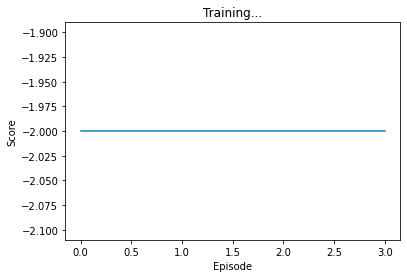

now epsilon is 0.9880022159439659, the reward is -330 with loss 202.12379405431096 in episode 4
#################  RESET GAME  ##################
Episode terminated after: 28 (s)
Total score: -203
#################################################


In [ ]:
resize = T.Compose([T.ToPILImage(),
                    T.Resize(84, interpolation=Image.CUBIC),
                    T.ToTensor()])

def process_screen(observation):
    # Returned screen requested by gym is 400x600x3, but is sometimes larger
    # such as 800x1200x3. Transpose it into torch order (CHW).
    screen = observation.transpose((2, 1, 0))
    screen = np.ascontiguousarray(screen, dtype=np.float32) / 255
    screen = torch.from_numpy(screen)
    # Resize, and add a batch dimension (BCHW)
    return resize(screen).unsqueeze(0).to(device)

episode_score = []

def plot_heights():
    if is_ipython:
        display.clear_output(wait=True)
        plt.figure(2)
        heights_t = torch.tensor(episode_score, dtype=torch.float)
        plt.title('Training...')
        plt.xlabel('Episode')
        plt.ylabel('Score')
        plt.plot(heights_t.numpy())
        # Take 100 episode averages and plot them too
        if len(heights_t) >= 100:
            means = heights_t.unfold(0, 100, 1).mean(1).view(-1)
            means = torch.cat((torch.zeros(99), means))
            plt.plot(means.numpy())
        plt.show()

env = MountainCar(speed=1e8, graphical_state=True, render=False, is_debug=True)
agent = MarioAgent(stateShape=(3, 84, 84),
                   actionSpace=env.get_action_space(), numPicks=128, memorySize=10000)

def episode():
    done = False
    rewardSum = 0
    lossSum = 0

    env.reset()
    currState = process_screen(env.get_state())
    lastState = currState
    state = currState - lastState

    maxScore = -100000

    while not done:
        stateT = Variable(state)

        action = agent.selectAction(stateT)
        obs, reward, done, score = env.step_all(action)
        maxScore =  max(  maxScore, score)
       
        reward = np.sum(reward)
        lastState = currState
        currState = process_screen(obs)

        if not done:
            nextState = Variable(currState - lastState).to(device)
        else:
            nextState = None

        #reward += obs[0]

        actionT = Variable(LongTensor([action])).to(device)
        rewardT = Variable(FloatTensor([reward])).to(device)
        doneT = Variable(BoolTensor([done])).to(device)

        rewardSum += reward
        state = nextState

        loss = agent.trainDQN()
        agent.addMemory((stateT, actionT, rewardT, nextState, doneT), loss)
        lossSum += loss

        if ep % 100 == 0:
            env.render()

    episode_score.append(maxScore)
    plot_heights()

    if ep % 200 == 0:
        agent.save()

    print("now epsilon is {}, the reward is {} with loss {} in episode {}".format(agent.epsilon, rewardSum, lossSum, ep)) 

ep = 1
while ep < 10000:
    episode()
    ep += 1

env.close()